# Federated Learning


### **Centralized Training**

* **What it means:** All data from different sources (users, devices, organizations) is collected and stored in a *single central location* — usually a server or cloud. The model is trained there.
* **Pros:**

  * Easier to manage: all data is in one place.
  * Training is often faster since computation can be optimized on big machines.
  * Standardized preprocessing and consistent updates.
* **Cons:**

  * Privacy risks: sensitive data must be shared with the central server.
  * Data transfer costs: moving large datasets can be expensive or slow.
  * Single point of failure if the server is compromised.

---

### **Decentralized Training (a.k.a. Federated)**

* **What it means:** Data stays where it is generated (e.g., on users’ phones, edge devices, or different organizations). Only *model updates* (like weights or gradients) are sent to a central server or shared peer-to-peer, not the raw data.
* **Pros:**

  * Preserves privacy since raw data never leaves local devices.
  * Can reduce communication cost if only updates are shared.
  * Makes use of distributed compute resources.
* **Cons:**

  * More complex to implement.
  * Models may converge slower due to differences in local data distributions.
  * Communication overhead when syncing updates across many devices.

---

💡 **Example contrast:**

* *Central training:* Imagine collecting hospital data from many clinics into one central database, then training an AI model for disease detection.
* *Non-central training:* Each hospital keeps its patient data locally, trains the model on-site, and only shares model updates. The global model then improves without anyone seeing raw patient data.

### **Introduction to Federated Learning**

Federated Learning is a machine learning approach that allows multiple devices (clients) to collaboratively train a model without sharing raw data. Instead of sending data to a central server, each client trains the model locally and only shares model updates (such as gradients or weights) with the server. This decentralized learning process is ideal for preserving privacy and reducing data transfer costs.

<div style="text-align: center;">
    <img src="https://www.dailydoseofds.com/content/images/2023/11/federated-gif.gif" alt="Epsilon Impact" width="700">
</div>


#### **The Client-Server Model**

In Federated Learning, there are two main components: the clients and the server. The server is responsible for aggregating the updates received from all participating clients, while the clients train the model using their own local data. The process typically follows these steps:
* **Server Initialization**: The server starts with an initial model.
* **Local Training**: Clients train the model on their own data and compute model updates (e.g., gradients or weights).
* **Update Aggregation**: Clients send their updates to the server.
* **Global Model Update**: The server aggregates the updates (often through methods like Federated Averaging) to improve the global model.
* **Iterative Process**: This process repeats for several rounds, improving the model over time without sharing sensitive data.

#### **Industry Use Cases**

Federated Learning has practical applications in industries where privacy, security, and distributed data are critical. For example:

* **Healthcare**: Medical institutions can train models to predict diseases based on patient data without transferring sensitive health information. Each hospital can keep its data local while still benefiting from a global model.
* **Finance**: Banks can use federated learning to detect fraud across different branches without needing to share their customer transaction data.
* **Mobile Devices**: Smartphone manufacturers, like Google, use federated learning to improve predictive text and other models while keeping users' data on their devices.

#### **Privacy and Security Concerns**

One of the key advantages of federated learning is privacy. By ensuring that only model updates are shared and not raw data, it helps protect sensitive information. However, there are still privacy concerns and potential attacks:

* **Data Poisoning**: Malicious clients could send faulty updates to corrupt the global model.
* **Inference Attacks**: Even without raw data, model updates could leak information about the local data. Sophisticated attackers might reverse-engineer patterns from the updates.
* **Model Inversion**: Attackers may try to infer private data from the trained model itself.

To mitigate these risks, techniques like differential privacy, secure aggregation, and encryption are often applied.

## Implementation

In this notebook, we simulate a federated learning setup using the MNIST dataset. The goal is to:
- Introduce the concept of **federated learning**.
- Prepare the dataset for federated training by simulating **10 clients**.


* Data Loading, Preprocessing, and Client Creation
* Data Analysis and Visualization
* Model Creation and Local Training
* Global Model Aggregation
* Evaluation After Global Update
* Insights and Discussion

## Import Required Libraries

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import collections
import random
from collections import defaultdict

## Dataset Overview

### Dataset: **MNIST**

- MNIST is a classic dataset of handwritten digits (0–9).
- It contains:
  - 60,000 training samples
  - 10,000 test samples
- Each image is 28×28 pixels in grayscale.


In [2]:
# Load EMNIST Balanced split
def load_emnist_data():
    (ds_train, ds_test), ds_info = tfds.load(
        'mnist',
        split=['train', 'test'],
        shuffle_files=True,
        as_supervised=True,
        with_info=True
    )
    return ds_train, ds_test, ds_info

ds_train, ds_test, ds_info = load_emnist_data()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist/incomplete.IMODDU_3.0.1/mnist-train.tfrecord*...:   0%|          | 0…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/mnist/incomplete.IMODDU_3.0.1/mnist-test.tfrecord*...:   0%|          | 0/…

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


## Data Preprocessing

We normalize each image to a `[0, 1]` range and add a channel dimension to match the expected input for CNNs.

Note:
- Unlike EMNIST, MNIST images are already correctly oriented.
- No need for rotation or flipping.


In [3]:
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0       # Normalize to [0,1]
    image = tf.expand_dims(image, axis=-1)           # Convert to (28, 28, 1)
    return {'pixels': image, 'label': label}

# Apply preprocessing
ds_train = ds_train.map(preprocess).cache()
ds_test = ds_test.map(preprocess).cache()

## Federated Data Partitioning

In federated learning, each client holds its own local dataset. We simulate this by splitting the dataset into smaller partitions.

This function does:
1. Gathers all data into memory.
2. Shuffles the dataset.
3. Partitions it into `num_clients` slices of equal size.


##Create Clients from Dataset

In [4]:
def create_clients_data(dataset, num_clients=50):
    """Partition dataset into num_clients subsets."""
    # Extract all data into memory
    data = []
    for example in dataset:
        pixels = example['pixels'].numpy()
        label = example['label'].numpy()
        data.append((pixels, label))

    # Shuffle data
    random.shuffle(data)

    # Calculate partition size
    total_samples = len(data)
    size_per_client = total_samples // num_clients
    print(f"Total samples: {total_samples}, Samples per client: {size_per_client}")

    client_datasets = []
    for i in range(num_clients):
        start = i * size_per_client
        end = start + size_per_client
        client_data = data[start:end]

        # Re-create tf.data.Dataset for each client
        pixels, labels = zip(*client_data)
        client_ds = tf.data.Dataset.from_tensor_slices({
            'pixels': tf.convert_to_tensor(pixels, dtype=tf.float32),
            'label': tf.convert_to_tensor(labels, dtype=tf.int64)
        })

        client_datasets.append(client_ds)

    return client_datasets

### Create Client Datasets

In [5]:
# Create federated client datasets
client_train_datasets = create_clients_data(ds_train, num_clients=10)
client_test_datasets = create_clients_data(ds_test, num_clients=10)

print(f"Number of training clients: {len(client_train_datasets)}")
print(f"Number of test clients: {len(client_test_datasets)}")

Total samples: 60000, Samples per client: 6000
Total samples: 10000, Samples per client: 1000
Number of training clients: 10
Number of test clients: 10


## Visualizing Client Data

## Visualizing Federated Client Data

Before diving into model training, it's essential to understand what kind of data each simulated client holds.

In this section, you'll:
- Visualize a few examples from a single client
- Examine the label distribution across multiple clients
- Plot the *mean image per label* per client — this helps see how digits vary per class across users

This is helpful to:
- Detect **non-IID behavior** (clients having biased or limited label ranges)
- Explain why federated learning is **harder than centralized learning**


Example label: 2


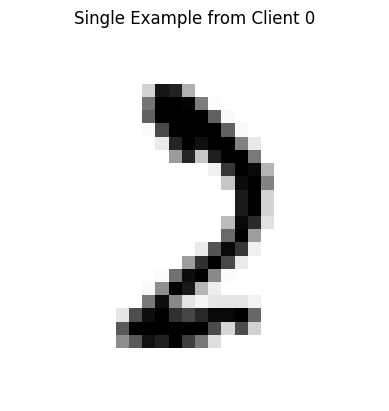

In [6]:
# View one example from the first client
example_dataset = client_train_datasets[0]
example_element = next(iter(example_dataset))

print(f"Example label: {example_element['label'].numpy()}")

plt.imshow(example_element['pixels'].numpy().squeeze(), cmap='gray_r')
plt.axis('off')
plt.grid(False)
plt.title("Single Example from Client 0")
plt.show()

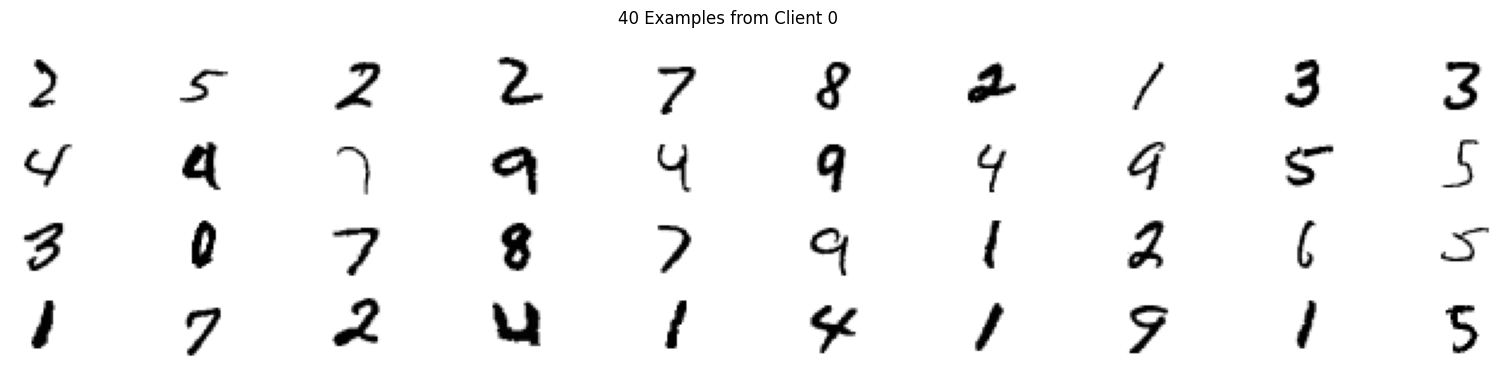

In [7]:
# Visualize more digits from the same client (Client 0)
figure = plt.figure(figsize=(20, 4))
for j, example in enumerate(example_dataset.take(40)):
    plt.subplot(4, 10, j + 1)
    plt.imshow(example['pixels'].numpy().squeeze(), cmap='gray_r')
    plt.axis('off')
plt.suptitle("40 Examples from Client 0")
plt.show()

## Label Distribution Per Client

## Label Distribution Across Clients

Clients in federated learning may have very different data distributions.
Some may have:
- Only a few classes (e.g., digits 0, 1, 2)
- Imbalanced datasets

Below, we visualize label distributions for 6 random clients.


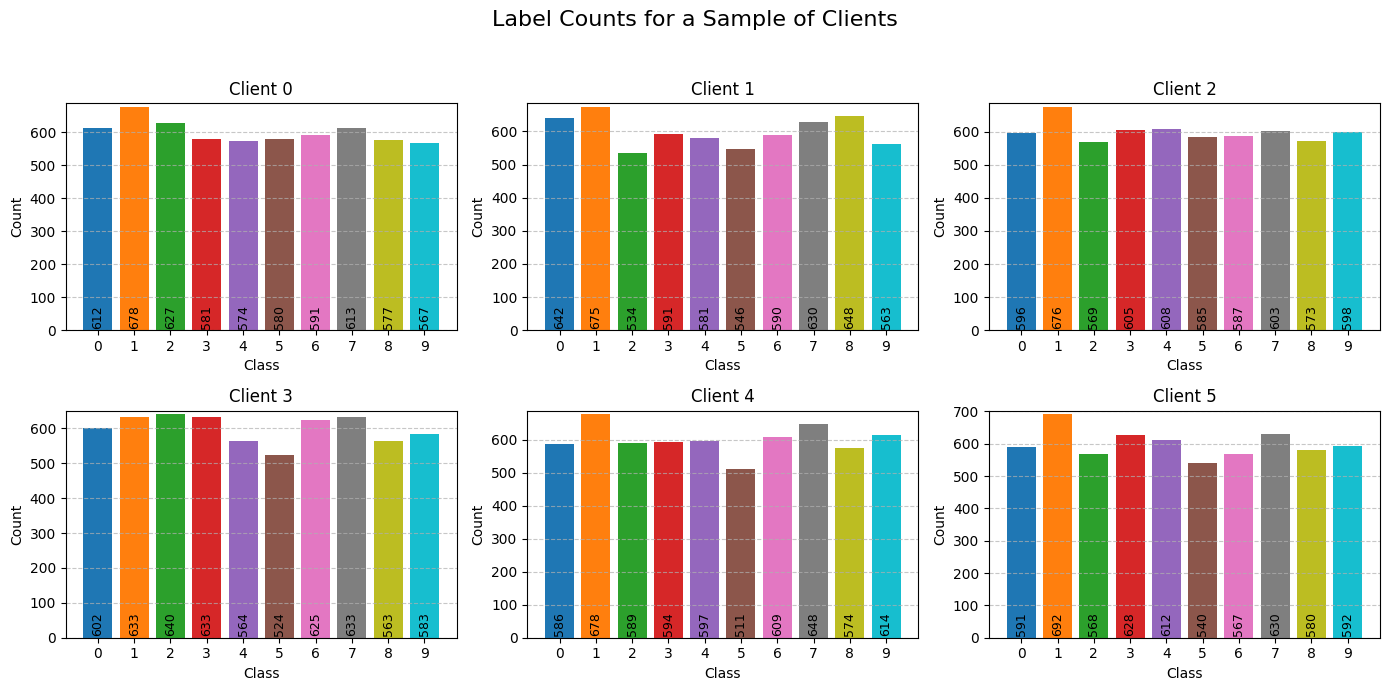

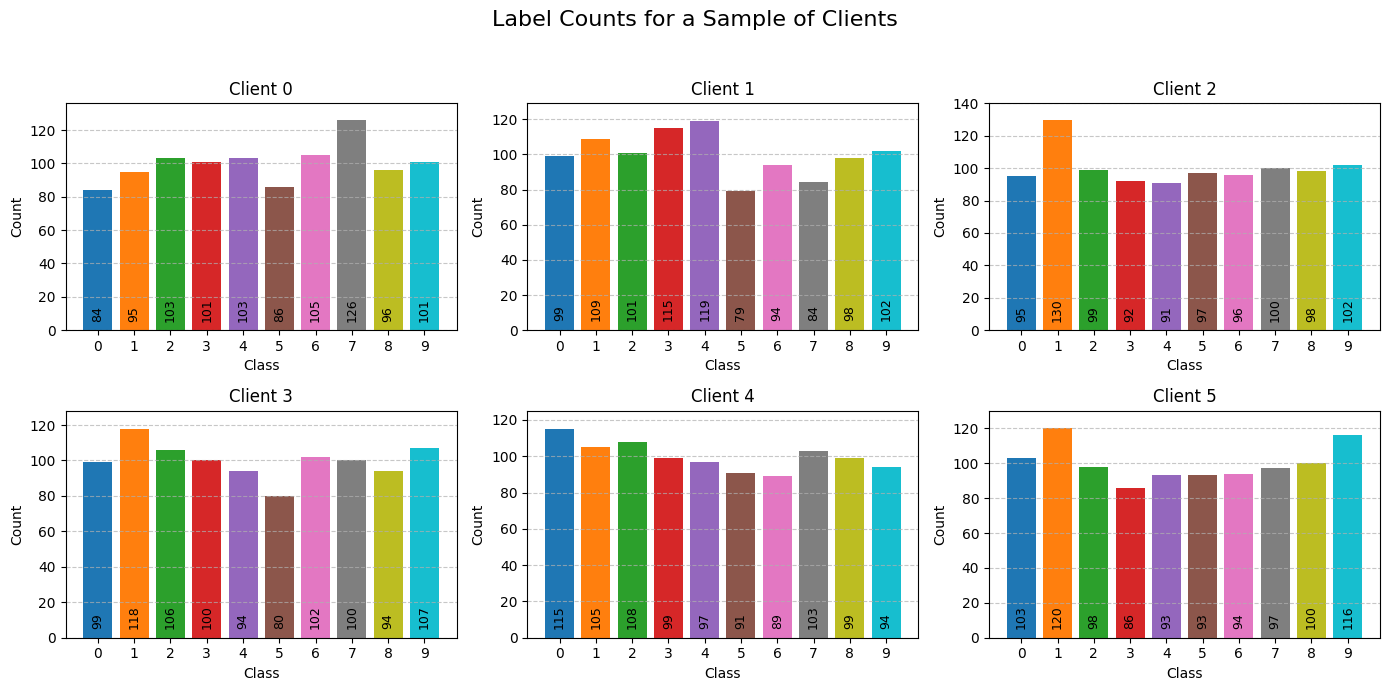

In [8]:
import collections

def plot_client_label_distribution(clients, num_clients_to_plot=6):
    f = plt.figure(figsize=(14, 7))
    f.suptitle('Label Counts for a Sample of Clients', fontsize=16)

    # Use a color palette with 10 unique colors (digits 0–9)
    cmap = plt.get_cmap('tab10')
    class_colors = [cmap(i) for i in range(10)]

    for i in range(num_clients_to_plot):
        plot_data = collections.defaultdict(list)

        for example in clients[i]:
            label = example['label'].numpy()
            plot_data[label].append(label)

        # Get sorted label counts
        class_ids = sorted(plot_data.keys())
        counts = [len(plot_data[k]) for k in class_ids]
        colors = [class_colors[c] for c in class_ids]

        # Create subplot
        ax = plt.subplot(2, 3, i + 1)
        bars = ax.bar(class_ids, counts, color=colors)

        # Add text labels
        for bar, count in zip(bars, counts):
            ax.text(bar.get_x() + bar.get_width() / 2, 5, str(count),
                    ha='center', va='bottom', fontsize=9, rotation=90)

        ax.set_title(f'Client {i}')
        ax.set_xlabel('Class')
        ax.set_ylabel('Count')
        ax.set_xticks(range(10))
        ax.set_ylim(0, max(counts) + 10)
        ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Plot distributions for both training and test clients
plot_client_label_distribution(client_train_datasets)
plot_client_label_distribution(client_test_datasets)

In federated learning, the way data is split matters a lot.

* **i.i.d. (independent and identically distributed):** Every client gets a random sample from the full dataset. For example, each client might have 0–9 digits in roughly equal proportions, just like the global MNIST distribution.

* **non-i.i.d.:** Clients have data that reflects only part of the distribution. For example, one client might only have images of digits *0* and *1*, while another has mostly *7s* and *9s*. This mirrors real-world cases, like different people writing digits in their own style or one user mainly texting certain words.

Non-i.i.d. data makes training harder because local models specialize on their client’s skewed data, so the aggregated global model may not perform well right away.

## 🧠 Mean Digit per Class for Each Client

This visualization computes the **average image** for each digit (0–9) on each client.
It helps answer:
- What does a "typical" 3 or 7 look like for this client?
- Is this client’s data biased toward specific handwriting styles?

Let’s plot this for the first 10 clients.


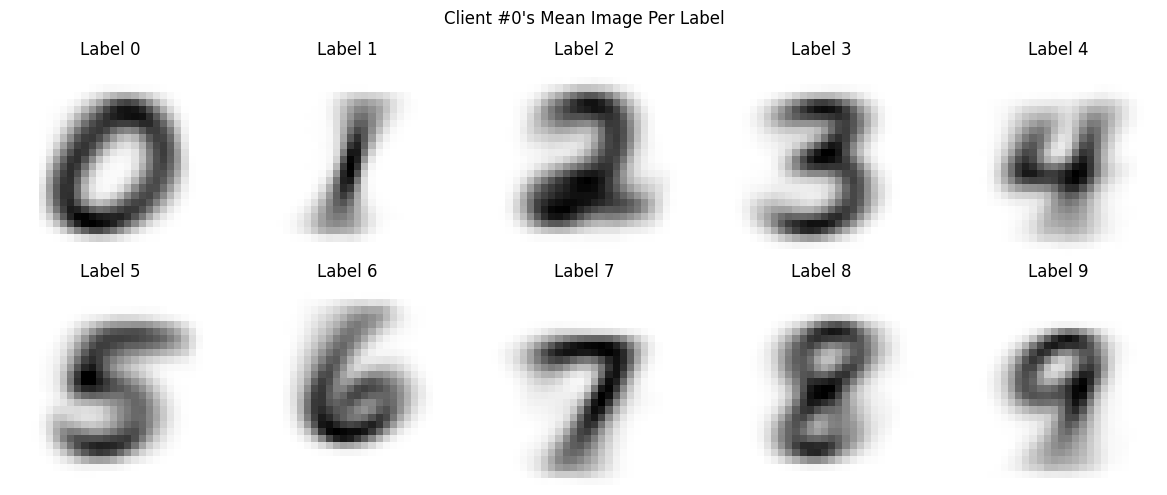

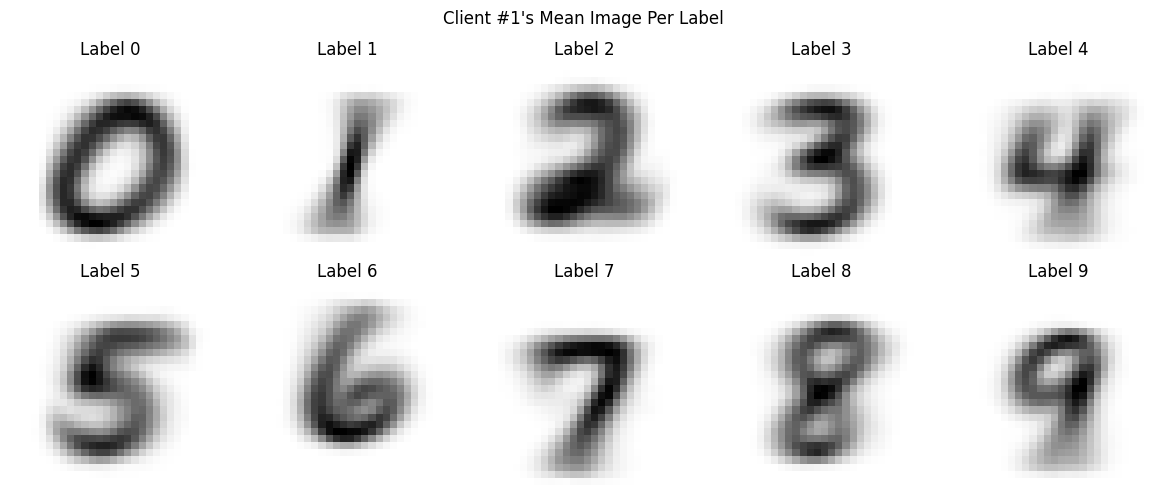

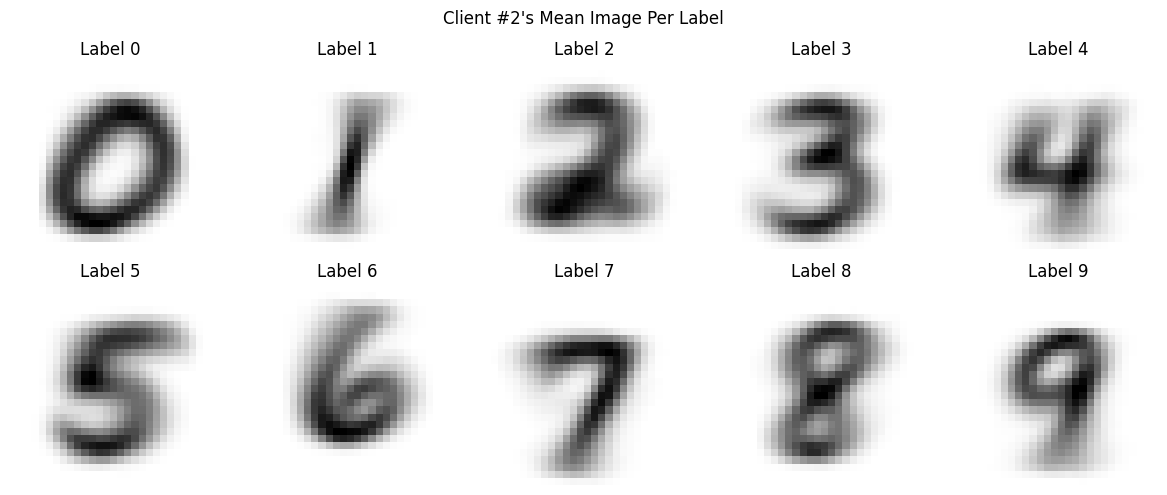

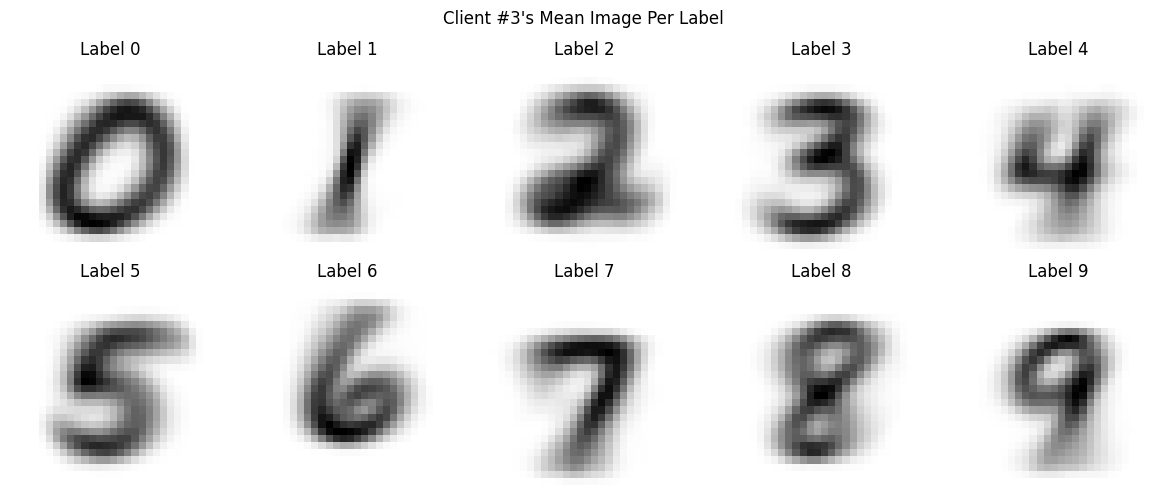

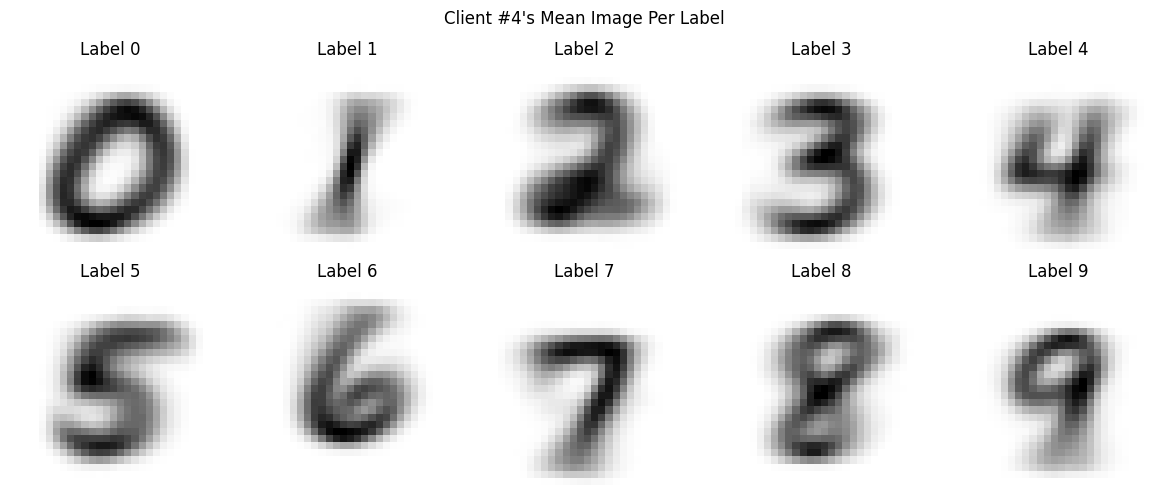

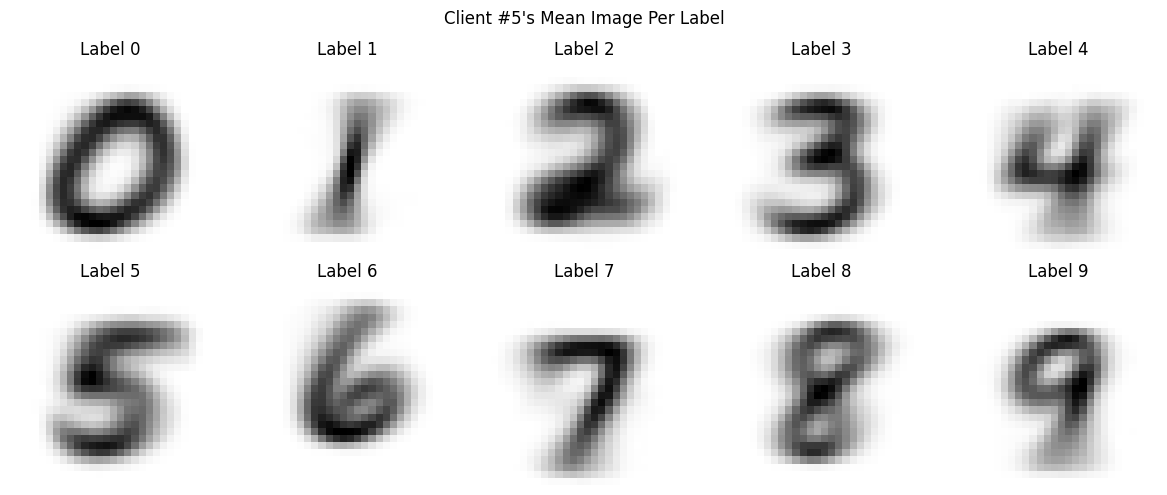

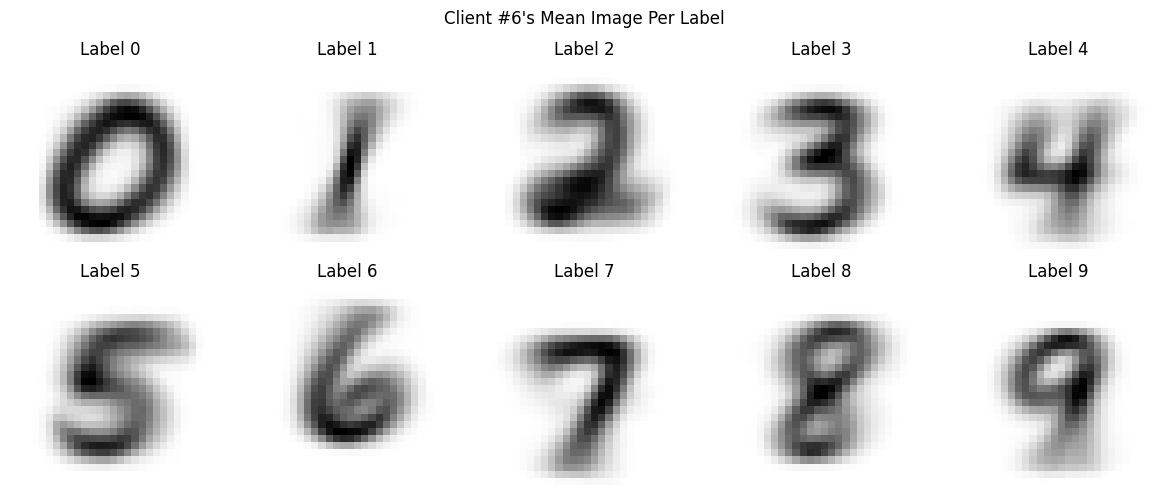

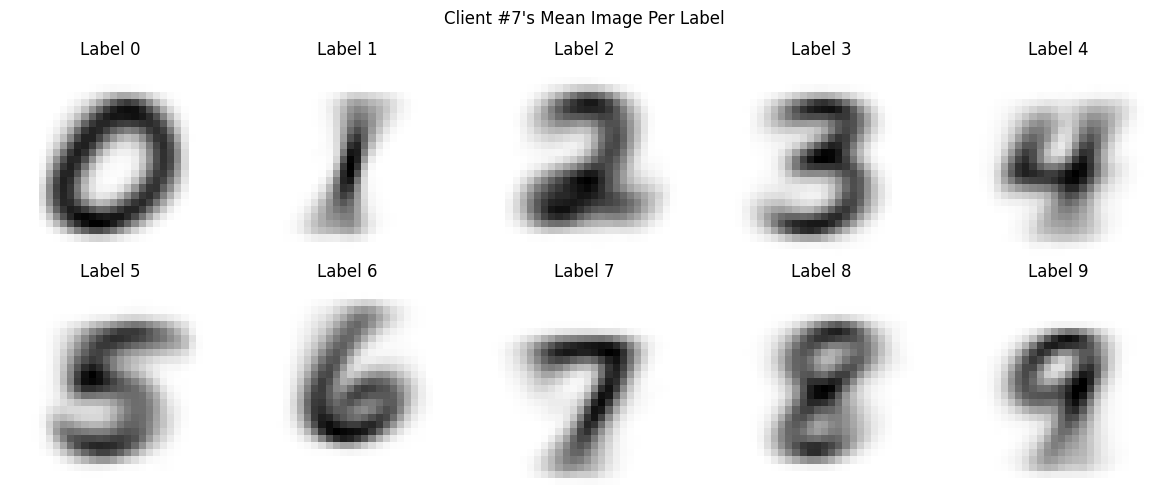

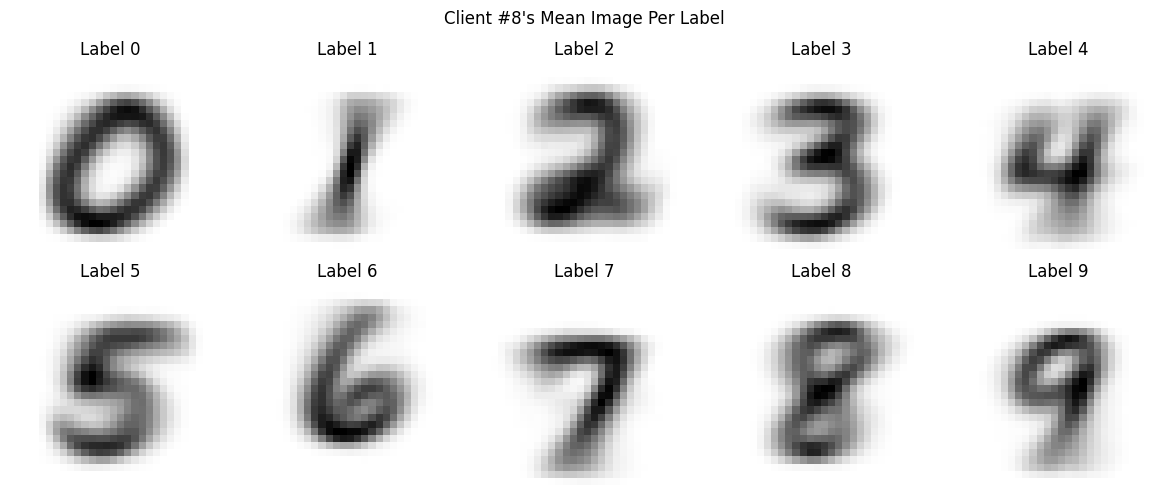

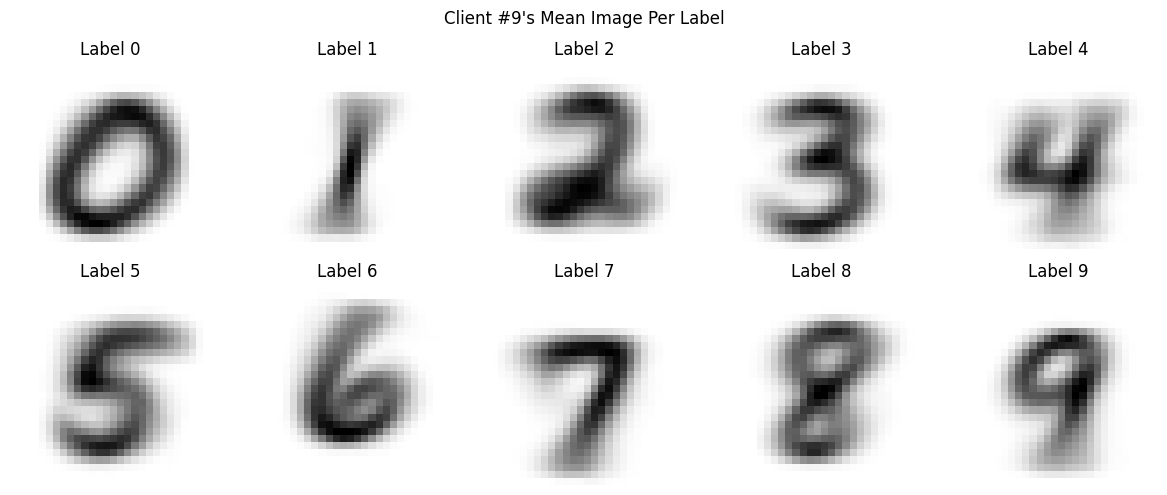

In [9]:
NUM_CLIENTS_TO_VISUALIZE = 10

for i in range(NUM_CLIENTS_TO_VISUALIZE):
    client_dataset = client_train_datasets[i]
    plot_data = collections.defaultdict(list)

    # Group pixels by label
    for example in client_dataset:
        label = example['label'].numpy()
        pixels = example['pixels'].numpy()
        plot_data[label].append(pixels)

    # Create figure for client
    f = plt.figure(i, figsize=(12, 5))
    f.suptitle(f"Client #{i}'s Mean Image Per Label")

    for j in range(10):
        if plot_data[j]:  # Only plot if the label exists
            mean_img = np.mean(plot_data[j], axis=0)
            plt.subplot(2, 5, j + 1)
            plt.imshow(mean_img.squeeze(), cmap='gray_r')
            plt.axis('off')
            plt.title(f"Label {j}")

    plt.tight_layout()
    plt.show()

In [10]:
BATCH_SIZE = 128
SHUFFLE_BUFFER = 100
PREFETCH_BUFFER = 10
NUM_CLIENTS = 10

def prepare_dataset(dataset, batch_size=32, shuffle=True):
    ds = dataset.map(lambda x: (x['pixels'], x['label']))
    if shuffle:
        ds = ds.shuffle(100)
    ds = ds.batch(batch_size)
    return ds.prefetch(tf.data.AUTOTUNE)


## Clients

Each client:
- Receives a copy of the global model from the **server**
- Trains it locally on their own dataset (which can be biased or imbalanced)
- Optionally adds **noise** to their model weights before sending them back to the server (for privacy)

The client’s behavior is controlled through a configuration dictionary (`params`), which lets us define:
- The optimizer (e.g., `SGD`, `Adam`)
- The loss function (e.g., `sparse_categorical_crossentropy`)
- Learning rate
- Whether to add noise, and how strong (`eps` parameter)

In [12]:
class Client:
    def __init__(self, client_id, train_dataset, test_dataset, model_fn, params=None):
        """
        params: dict that may include:
            - 'optimizer': str (e.g., 'SGD', 'Adam')
            - 'learning_rate': float
            - 'loss': str or tf.keras loss
            - 'add_noise': bool
            - 'eps': float (magnitude of noise)
        """
        self.client_id = client_id
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.model = model_fn()
        self.params = params or {}

        # Extract config
        self.optimizer_name = self.params.get('optimizer', 'SGD')
        self.learning_rate = self.params.get('learning_rate', 0.01)
        self.loss = self.params.get('loss', 'sparse_categorical_crossentropy')
        self.add_noise = self.params.get('add_noise', False)
        self.eps = self.params.get('eps', 1e-3)  # noise strength

    def train(self, initial_weights, epochs=1, batch_size=32):
        self.model.set_weights(initial_weights)

        optimizer = self._get_optimizer(self.optimizer_name, self.learning_rate)
        self.model.compile(optimizer=optimizer, loss=self.loss, metrics=['accuracy'])

        history = self.model.fit(self.train_dataset, epochs=epochs, verbose=0)

        updated_weights = self.model.get_weights()

        if self.add_noise:
            updated_weights = self._add_noise(updated_weights, self.eps)

        metrics = {
            'loss': history.history['loss'][-1],
            'accuracy': history.history['accuracy'][-1]
        }

        return updated_weights, metrics

    def update_weights(self, new_weights):
        self.model.set_weights(new_weights)

    def evaluate(self, batch_size=32):
        self.model.compile(
            optimizer=self._get_optimizer(self.optimizer_name, self.learning_rate),  # dummy use
            loss=self.loss,
            metrics=['accuracy']
        )
        loss, acc = self.model.evaluate(self.test_dataset, verbose=0)
        return {'loss': loss, 'accuracy': acc}

    def _get_optimizer(self, name, lr):
        name = name.lower()
        if name == 'adam':
            return tf.keras.optimizers.Adam(learning_rate=lr)
        elif name == 'sgd':
            return tf.keras.optimizers.SGD(learning_rate=lr)
        else:
            raise ValueError(f"Unsupported optimizer: {name}")

    def _add_noise(self, weights, eps):
        noisy_weights = []
        for w in weights:
            noise = np.random.normal(loc=0.0, scale=eps, size=w.shape)
            noisy_weights.append(w + noise)
        return noisy_weights

## Server

The server:
- Aggregates client models using **Federated Averaging (FedAvg)**
- Computes a **weighted average** of client models (weighted by number of local samples)
- Distributes the new global model to all clients for the next round

In [18]:
class Server:
    def __init__(self, model_fn):
        self.model = model_fn()

    def get_weights(self):
        return self.model.get_weights()

    def aggregate(self, client_weights, client_sizes):
        total_samples = sum(client_sizes)
        new_weights = []
        for weights_list in zip(*client_weights):
            weighted_sum = sum(w * (size / total_samples) for w, size in zip(weights_list, client_sizes))
            new_weights.append(weighted_sum)
        self.model.set_weights(new_weights)

    def get_model(self):
        return self.model

## Federated Training Loop Explained

We simulate multiple rounds of communication between:
- Clients: each trains a model on local data, and optionally adds noise
- Server: averages models using **FedAvg** and distributes updated weights

Each round includes:
1. Server sends current weights to all clients
2. Clients train locally and send updates (with or without noise)
3. Server aggregates updates (weighted by data size)
4. Updated global model is distributed again

We log both training and test performance for transparency.

In [14]:
def run_federated_learning(clients, server, rounds=5, epochs_per_client=1):
    for round_num in range(1, rounds + 1):
        print(f"\n--- Federated Round {round_num} ---")

        # 1. Get current global model weights from the server
        initial_weights = server.get_weights()

        client_weights = []
        client_sizes = []
        round_train_metrics = []

        # 2. Local training on each client
        for client in clients:
            weights, metrics = client.train(
                initial_weights=initial_weights,
                epochs=epochs_per_client
            )
            client_weights.append(weights)

            # Count number of samples (batches * batch size)
            client_size = sum(1 for _ in client.train_dataset)
            client_sizes.append(client_size)

            round_train_metrics.append((client.client_id, metrics))

        # 3. Report training metrics
        print("Client Training Metrics:")
        for cid, m in round_train_metrics:
            print(f"Client {cid} — Loss: {m['loss']:.4f}, Acc: {m['accuracy']:.4f}")

        # 4. Aggregate weights on server (FedAvg)
        server.aggregate(client_weights, client_sizes)

        # 5. Distribute new global model weights to clients
        updated_weights = server.get_weights()
        for client in clients:
            client.update_weights(updated_weights)

        # 6. Evaluate each client on its local test dataset
        print("Client Evaluation Metrics:")
        for client in clients:
            metrics = client.evaluate()
            print(f"Client {client.client_id} — Test Loss: {metrics['loss']:.4f}, Test Acc: {metrics['accuracy']:.4f}")

## **Model Description**

This Convolutional Neural Network (CNN) is designed for digit classification on grayscale images (such as MNIST). It includes a series of convolutional and pooling layers to extract features, followed by dense layers for classification.

1. **Input Layer**  
   Accepts images of shape `(28, 28, 1)` — grayscale digit images.

2. **Convolutional Layers**  
   - **First Conv Layer:** 32 filters of size (3×3), ReLU activation, followed by max pooling (2×2).  
   - **Second Conv Layer:** 64 filters of size (3×3), ReLU activation, followed by max pooling (2×2).

3. **Flatten Layer**  
   Transforms the 2D feature maps into a 1D feature vector for the dense layers.

4. **Dense Layer**  
   Fully connected layer with 128 neurons and ReLU activation.

5. **Output Layer**  
   10 neurons with softmax activation, representing the 10 digit classes (0–9).

---

The model is typically compiled using the **SGD optimizer**, **sparse categorical cross-entropy** as the loss function, and **accuracy** as the performance metric.


### Summary

| Layer               | Output Shape      | Parameters | Role                           |
|--------------------|------------------|------------|--------------------------------|
| Input               | (28, 28, 1)       | 0          | Declares input shape           |
| Conv2D (32 filters) | (26, 26, 32)      | 320        | Extract low-level features     |
| MaxPooling2D        | (13, 13, 32)      | 0          | Downsample feature maps        |
| Conv2D (64 filters) | (11, 11, 64)      | 18,496     | Extract complex features       |
| MaxPooling2D        | (5, 5, 64)        | 0          | Downsample again               |
| Flatten             | (1600,)           | 0          | Flatten 3D to 1D vector        |
| Dense(128)          | (128,)            | 204,928    | Learn high-level representations |
| Dense(10)           | (10,)             | 1,290      | Output class probabilities     |

**Total Parameters:** ~225,034  
**Suitable for:** Digit classification tasks in both centralized and federated settings.


In [15]:
def create_cnn_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(28, 28, 1)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')  # 10 digit classes
    ])
    return model

## Federated Security Enhancement: Adding Weight Noise

To increase resistance to privacy attacks (e.g., inference or reconstruction), clients can inject **small Gaussian noise** into their model weights before sharing with the server.

- Controlled via `add_noise=True` when creating the client
- `eps` controls how strong the noise is:
  - `eps=1e-3` — very light
  - `eps=1e-2` — moderate (may affect accuracy)
  - `eps=1e-1` — strong noise, only for experimentation

This technique simulates **local differential privacy** and makes model updates less directly tied to exact local data.


In [21]:
# Create 10 clients with shared model config and optional noise
client_params = {
    'optimizer': 'SGD',
    'learning_rate': 0.001,
    'loss': 'sparse_categorical_crossentropy',
    'add_noise': True,
    'eps': 1e-3  # Light Gaussian noise
}

clients = []
for i in range(10):
    train_ds = prepare_dataset(client_train_datasets[i], batch_size=32)
    test_ds = prepare_dataset(client_test_datasets[i], batch_size=32)
    clients.append(Client(client_id=i,
                          train_dataset=train_ds,
                          test_dataset=test_ds,
                          model_fn=create_cnn_model,
                          params=client_params))

In [22]:
# 3. Create server
server = Server(model_fn=create_cnn_model)


In [23]:
# Run federated learning
run_federated_learning(
    clients=clients,
    server=server,
    rounds=5,
    epochs_per_client=3,
)


--- Federated Round 1 ---
Client Training Metrics:
Client 0 — Loss: 2.2631, Acc: 0.1495
Client 1 — Loss: 2.2636, Acc: 0.1697
Client 2 — Loss: 2.2650, Acc: 0.1517
Client 3 — Loss: 2.2642, Acc: 0.1628
Client 4 — Loss: 2.2659, Acc: 0.1925
Client 5 — Loss: 2.2652, Acc: 0.1668
Client 6 — Loss: 2.2650, Acc: 0.1762
Client 7 — Loss: 2.2621, Acc: 0.1798
Client 8 — Loss: 2.2652, Acc: 0.1883
Client 9 — Loss: 2.2657, Acc: 0.1710
Client Evaluation Metrics:
Client 0 — Test Loss: 2.2527, Test Acc: 0.2240
Client 1 — Test Loss: 2.2570, Test Acc: 0.2050
Client 2 — Test Loss: 2.2542, Test Acc: 0.2000
Client 3 — Test Loss: 2.2559, Test Acc: 0.2030
Client 4 — Test Loss: 2.2559, Test Acc: 0.1950
Client 5 — Test Loss: 2.2531, Test Acc: 0.2220
Client 6 — Test Loss: 2.2543, Test Acc: 0.2450
Client 7 — Test Loss: 2.2543, Test Acc: 0.2080
Client 8 — Test Loss: 2.2532, Test Acc: 0.2000
Client 9 — Test Loss: 2.2541, Test Acc: 0.2080

--- Federated Round 2 ---
Client Training Metrics:
Client 0 — Loss: 2.1776, Acc: